In [20]:
import pandas as pd

combine_df = pd.read_csv('../data/curated/combine_all.csv')

In [21]:
combine_df = combine_df.dropna()

In [22]:

for column in combine_df.columns:
    if combine_df[column].dtype == 'object':
        print(f"Column '{column}' has number of unique values: {len(combine_df[column].unique())}")

   

Column 'promoType' has number of unique values: 5
Column 'agentNames' has number of unique values: 1193
Column 'brandName' has number of unique values: 529
Column 'addressStreet' has number of unique values: 2885
Column 'addressSuburb' has number of unique values: 30
Column 'addressState' has number of unique values: 1
Column 'type' has number of unique values: 9
Column 'formatted' has number of unique values: 9
Column 'nearest_station' has number of unique values: 63


In [23]:
df = combine_df.drop(columns=['agentNames', 'brandName', 'addressStreet', 
                              'addressSuburb', 'addressState',
                               'id','addressLat','addressLng','formatted'])

In [24]:
numeric_features = df.select_dtypes(exclude=['object']).columns.to_list()

In [25]:
categorical_features = []
for col in df.columns:
    if col not in numeric_features:
        categorical_features.append(col)

categorical_features

['promoType', 'type', 'nearest_station']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



X = df.drop(columns='price')
y = df['price']
         
# Split the data
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features[1:]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Initialize and train new models
rf_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


complex_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

linear_reg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_reg_model.fit(X_train, y_train)
y_linear_reg_pred = linear_reg_model.predict(X_test)

# Fit the models
rf_reg_model.fit(X_train, y_train)
complex_reg_model.fit(X_train, y_train)

# Predictions
y_rf_reg_pred = rf_reg_model.predict(X_test)
y_complex_reg_pred = complex_reg_model.predict(X_test)


# Evaluation
# Regression Model Performance (Simple and Complex)
rf_reg_mse = mean_squared_error(y_test, y_rf_reg_pred)
rf_reg_r2 = r2_score(y_test, y_rf_reg_pred)

complex_reg_mse = mean_squared_error(y_test, y_complex_reg_pred)
complex_reg_r2 = r2_score(y_test, y_complex_reg_pred)


linear_reg_mse = mean_squared_error(y_test, y_linear_reg_pred)
linear_reg_r2 = r2_score(y_test, y_linear_reg_pred)


# Prepare the comparison table for regression
regression_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MSE': [linear_reg_mse, rf_reg_mse, complex_reg_mse],
    'R-squared': [linear_reg_r2, rf_reg_r2, complex_reg_r2]
})



In [28]:
regression_comparison 

,Model,MSE,R-squared
0,Linear Regression,20401.941606,0.506025
1,Random Forest,19275.860906,0.533290
2,Gradient Boosting,17702.698485,0.571380


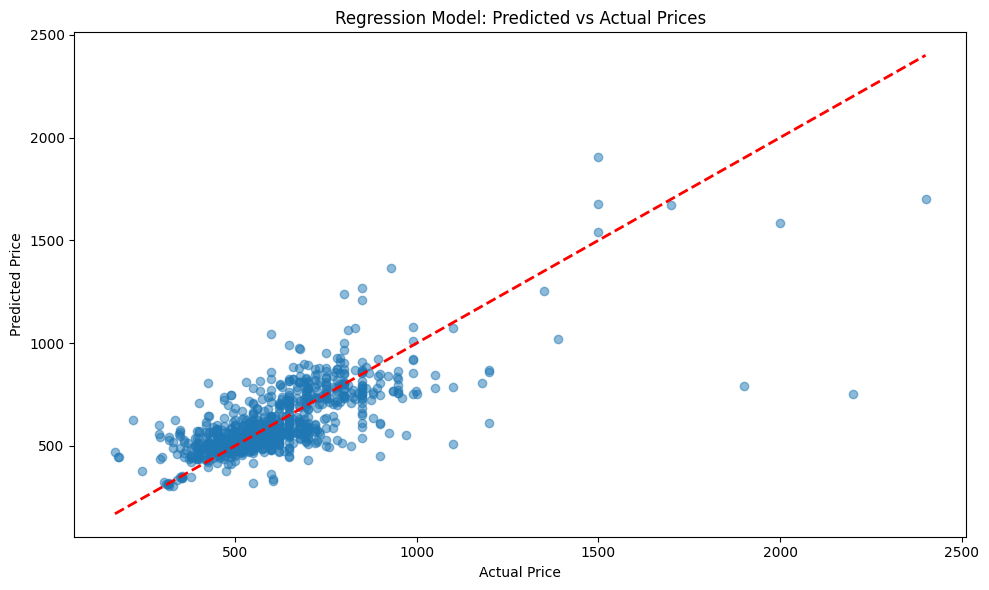

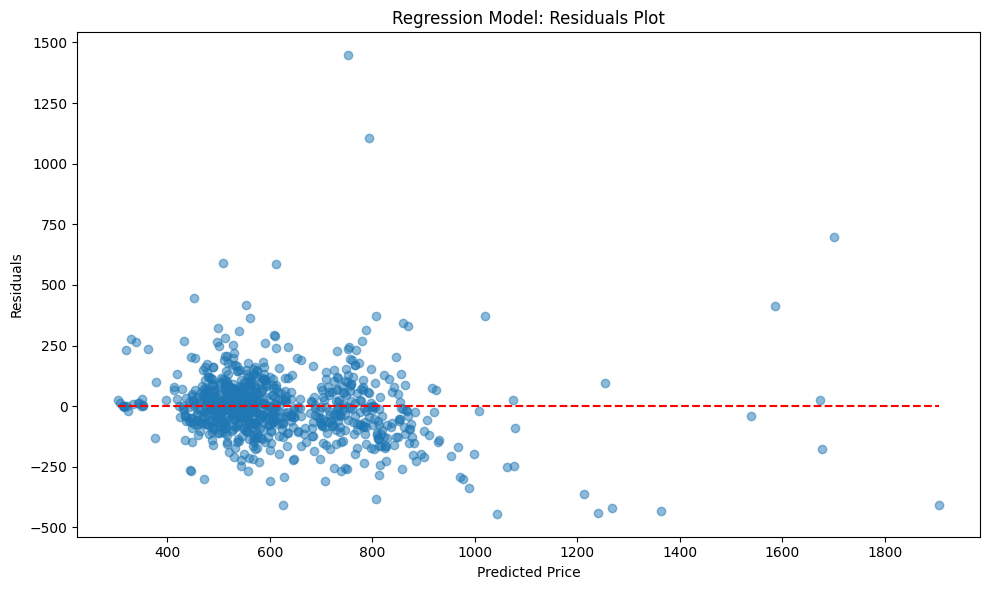

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Regression Model - Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_rf_reg_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression Model: Predicted vs Actual Prices')
plt.tight_layout()
plt.show()

# Visualization 2: Regression Model - Residuals Plot
residuals = y_test - y_rf_reg_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_rf_reg_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_rf_reg_pred.min(), xmax=y_rf_reg_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Regression Model: Residuals Plot')
plt.tight_layout()
plt.show()

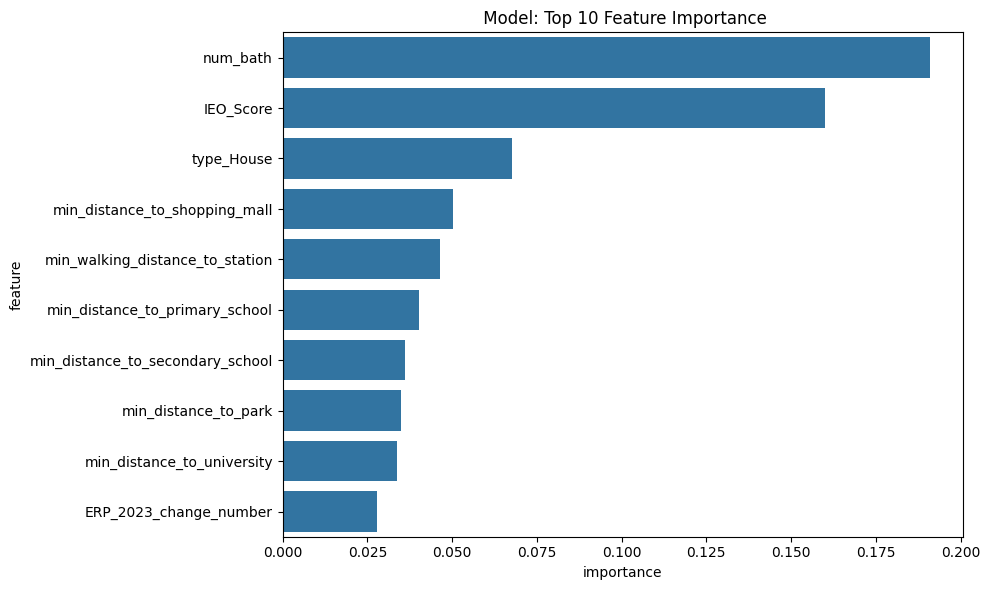

In [30]:
# Visualization 4: Classification Model - Feature Importance
feature_importance = rf_reg_model.named_steps['regressor'].feature_importances_
feature_names = (numeric_features[1:] +
                 rf_reg_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(' Model: Top 10 Feature Importance')
plt.tight_layout()
plt.show()